In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

## 处理数据

In [2]:
data = pd.read_csv('50ETF_OPTION_INFO.csv',sep='\t',encoding='gbk')
etf = pd.read_csv('50ETF报价.csv',sep=',')
rf = pd.read_csv('SHIBOR1月.csv')

In [3]:
rf['日期'] = pd.to_datetime(rf['日期'])
etf['date'] = pd.to_datetime(etf['date'])
data['date'] = pd.to_datetime(data['date'])
data['exercise_date'] = pd.to_datetime(data['exercise_date'])
data['type'] = data['trading_code'].apply(lambda x: x[6])

## 算例

In [12]:
temp = data[data['date']=='2015-02-09']

In [13]:
temp_call = temp[temp['type']=='C']
temp_put = temp[temp['type']=='P']

In [14]:
temp_call.head()

,code,date,open,high,close,low,settle_price,volume,money,position,exercise_date,name,trading_code,exercise_price,type
2261,10000034.XSHG,2015-02-09,0.2828,0.2828,0.2326,0.2326,0.3992,160,418325.0,129,2015-09-23,50ETF购9月2350,510050C1509M02350,2.35,C
139,10000005.XSHG,2015-02-09,0.0868,0.0894,0.0735,0.0712,0.1844,1411,1163397.0,386,2015-03-25,50ETF购3月2400,510050C1503M02400,2.40,C
2414,10000035.XSHG,2015-02-09,0.2621,0.2621,0.2116,0.2116,0.3731,194,463183.0,127,2015-09-23,50ETF购9月2400,510050C1509M02400,2.40,C
929,10000022.XSHG,2015-02-09,0.2550,0.2550,0.2366,0.2366,0.4024,114,286345.0,75,2015-06-24,50ETF购6月2250,510050C1506M02250,2.25,C
1802,10000031.XSHG,2015-02-09,0.3531,0.3541,0.3130,0.3080,0.4955,247,818368.0,224,2015-09-23,50ETF购9月2200,510050C1509M02200,2.20,C


参考Leon和Bakshi等的方法，收益的风险中性偏度可从上证50ETF报价和对应期权信息中算出，该分布的偏度为:

$$Skew = \frac{e^{r_{t}\tau}W(t,\tau)-3\mu(t,\tau)e^{r_{t}\tau}V(t,\tau)+2\mu(t,\tau)^3}{(e^{r_{t}\tau}V(t,\tau)-\mu(t,\tau)^2)^\frac{3}{2}} \tag{1}$$

其中，

$$\mu(t,\tau)=e^{r_{t}\tau}-1-\frac{1}{2!}e^{r_{t}\tau}V(t,\tau)-\frac{1}{3!}e^{r_{t}\tau}W(t,\tau)-\frac{1}{4!}e^{r_{t}\tau}U(t,\tau) \tag{2}$$

利用期权的存续期$\tau$，行权价格$K$，ETF的现价$S_t$，可算出$V$，$W$和$U$：

.
$$V(t,\tau)=\int_{S_t}^{\infty}\frac{2(1-ln(\frac{K}{S_t}))}{K^2}C(t,\tau,K)dK+\int_{\infty}^{S_t}\frac{2(1+ln(\frac{S_t}{K}))}{K^2}P(t,\tau,K)dK \tag{3}$$

.

$$W(t,\tau)=\int_{S_t}^{\infty}\frac{6ln(\frac{K}{S_t})-3(ln(\frac{K}{S_t}))^2}{K^2}C(t,\tau,K)dK - \int_{S_t}^{\infty}\frac{6ln(\frac{S_t}{K})+3(ln(\frac{S_t}{K}))^2}{K^2}P(t,\tau,K)dK \tag{4}$$

.

$$U(t,\tau)=\int_{S_t}^{\infty}\frac{12ln(\frac{K}{S_t})^2-4(ln(\frac{K}{S_t}))^3}{K^2}C(t,\tau,K)dK+\int_{S_t}^{\infty}\frac{12ln(\frac{S_t}{K})^2+4(ln(\frac{S_t}{K}))^3}{K^2}P(t,\tau,K)dK \tag{5}$$

由于深度虚值期权被行权的可能很小，其被积函数趋于零，由行权价不连续导致的数值积分误差可忽略

In [30]:
etf_price = etf[etf['date']==temp_call['date'].iloc[0]]['close'].iloc[0]
T_to_t = (temp['exercise_date'].iloc[0]-temp['date'].iloc[0]).days/365
r = rf[rf['日期']==temp_call['date'].iloc[0]]['价格'].iloc[0]/100

v1 = sum(temp_call.apply(lambda x: 2*(1-np.log(etf_price/x['exercise_price']))/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
v2 = sum(temp_put.apply(lambda x: 2*(1-np.log(etf_price/x['exercise_price']))/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
v = v1+v2
w1 = sum(temp_call.apply(lambda x:(6*np.log(x['exercise_price']/etf_price)-3*np.log(x['exercise_price']/etf_price)**2)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
w2 = sum(temp_put.apply(lambda x:(6*np.log(x['exercise_price']/etf_price)-3*np.log(x['exercise_price']/etf_price)**2)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
w = w1+w2
u1 = sum(temp_call.apply(lambda x:(12*np.log(x['exercise_price']/etf_price)**2-4*np.log(x['exercise_price']/etf_price)**3)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
u2 = sum(temp_put.apply(lambda x:(12*np.log(x['exercise_price']/etf_price)**2-4*np.log(x['exercise_price']/etf_price)**3)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
u = u1+u2
m = np.exp(r*T_to_t)-1-(np.exp(r*T_to_t)*v)/factorial(2)-(np.exp(r*T_to_t)*w)/factorial(3)-(np.exp(r*T_to_t)*u)/factorial(4)
skew = (np.exp(r*T_to_t)*w-3*m*np.exp(r*T_to_t)*v+2*m**3)/((np.exp(r*T_to_t)*v-m**2)**1.5)
kurt = (np.exp(r*T_to_t)*u-4*m*np.exp(r*T_to_t)*w+6*np.exp(r*T_to_t)*v*m**2-3*m**4)/((np.exp(r*T_to_t)*v-m**2)**2)

In [31]:
print('风险中性偏度为{}'.format(skew))
print('风险中性峰度为{}'.format(kurt))

风险中性偏度为0.7619568135300722
风险中性峰度为0.4165630670922075


## 生成Skew序列

In [9]:
data = data.sort_values(by='date')
x = data.groupby(data['date'])

In [37]:
def cal_RN_skew(temp_call,temp_put,etf_price,T_to_t,r):
    v1 = sum(temp_call.apply(lambda x: 2*(1-np.log(x['exercise_price']/etf_price))/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
    v2 = sum(temp_put.apply(lambda x: 2*(1+np.log(etf_price/x['exercise_price']))/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
    v = v1+v2
    w1 = sum(temp_call.apply(lambda x:(6*np.log(x['exercise_price']/etf_price)-3*np.log(x['exercise_price']/etf_price)**2)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
    w2 = sum(temp_put.apply(lambda x:(6*np.log(etf_price/x['exercise_price'])+3*np.log(etf_price/x['exercise_price'])**2)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
    w = w1-w2
    u1 = sum(temp_call.apply(lambda x:(12*np.log(x['exercise_price']/etf_price)**2-4*np.log(x['exercise_price']/etf_price)**3)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
    u2 = sum(temp_put.apply(lambda x:(12*np.log(etf_price/x['exercise_price'])**2+4*np.log(etf_price/x['exercise_price'])**3)/(x['exercise_price']**2)*0.05*x['settle_price'],axis=1))
    u = u1+u2
    m = np.exp(r*T_to_t)-1-(np.exp(r*T_to_t)*v)/factorial(2)-(np.exp(r*T_to_t)*w)/factorial(3)-(np.exp(r*T_to_t)*u)/factorial(4)
    skew = (np.exp(r*T_to_t)*w-3*m*np.exp(r*T_to_t)*v+2*m**3)/((np.exp(r*T_to_t)*v-m**2)**1.5)
    kurt = (np.exp(r*T_to_t)*u-4*m*np.exp(r*T_to_t)*w+6*np.exp(r*T_to_t)*v*m**2-3*m**4)/((np.exp(r*T_to_t)*v-m**2)**2)
    return skew,kurt

每天存在不同存续期的期权，t时刻的风险中性偏度等于当天不同存续期的风险中性偏度的均值。

In [53]:
skew_dic = dict()
kurt_dic = dict()
#主循环：计算每天的隐含偏度
for name,group in x:
    try:
        #对当天的期权按照不同存续期再次分组
        temp_group = group.groupby(group['exercise_date'])
        temp_skew = []
        temp_kurt = []
        #计算每个存续期在当天的隐含偏度
        for sub_name,sub_group in temp_group:
            temp_call = sub_group[sub_group['type']=='C']
            temp_put = sub_group[sub_group['type']=='P']
            
            r = rf[rf['日期']==name]['价格'].iloc[0]/100
            S = etf[etf['date']==name]['close'].iloc[0]
            T_to_t = (sub_group['exercise_date'].iloc[0]-sub_group['date'].iloc[0]).days/365
            
            skew1,kurt1 = cal_RN_skew(temp_call,temp_put,S,T_to_t,r)
            temp_skew.append(skew1)
            temp_kurt.append(kurt1)
        #对不同存续期对应的隐含偏度取均值
        skew = np.mean(temp_skew)
        kurt = np.mean(temp_kurt)
        skew_dic[name]=skew
        kurt_dic[name]=kurt
    except Exception:
        pass

## 画图

### 隐含偏度与50ETF收盘价

In [54]:
df = pd.DataFrame.from_dict(skew_dic,orient='index',columns=['skew'])
df['S']=etf[etf['date'].isin(df.index.tolist())]['close'].tolist()

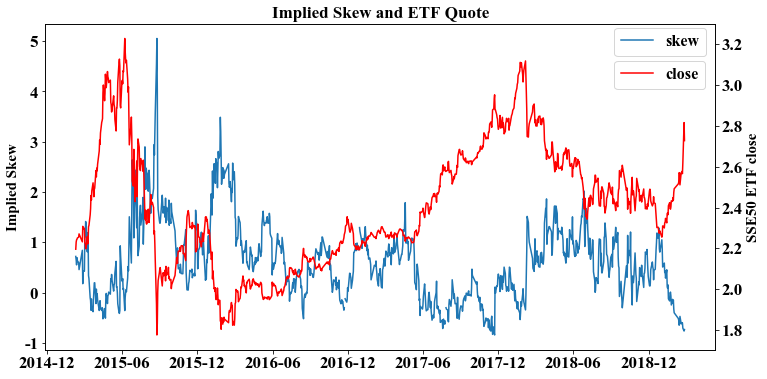

In [66]:
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

ax1 = fig.add_subplot(1,1,1)
ax1.plot(df['skew'],label='skew')

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.ylabel('Implied Skew',fontsize=15)
plt.title('Implied Skew and ETF Quote',fontsize=17)

ax2 = ax1.twinx()
ax2.plot(df['S'], color='r',label='close')

plt.yticks(fontsize=17)
plt.ylabel('SSE50 ETF close',fontsize=15)

ax1.legend(loc=(0.85,0.9),fontsize=16)
ax2.legend(loc=(0.85,0.8),fontsize=16)

### 隐含峰度与50ETF收盘价

In [56]:
df2 = pd.DataFrame.from_dict(kurt_dic,orient='index',columns=['kurt'])
df2['S']=etf[etf['date'].isin(df2.index.tolist())]['close'].tolist()

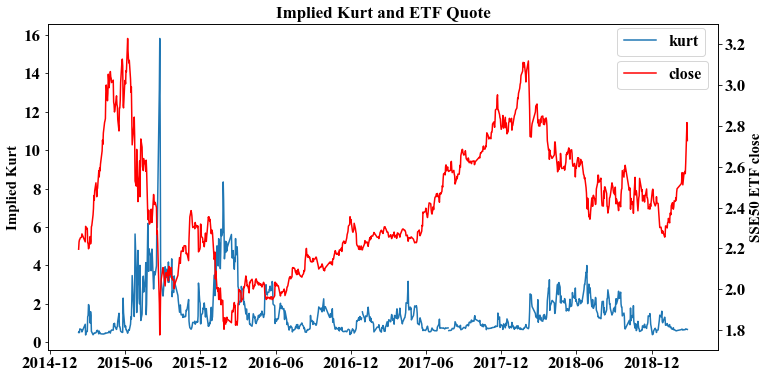

In [68]:
fig2 = plt.figure(figsize=(12,6))
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

ax1 = fig2.add_subplot(1,1,1)
ax1.plot(df2['kurt'],label='kurt')

plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.ylabel('Implied Kurt',fontsize=15)
plt.title('Implied Kurt and ETF Quote',fontsize=17)

ax2 = ax1.twinx()  
ax2.plot(df2['S'], color='r',label='close')

plt.yticks(fontsize=17)
plt.ylabel('SSE50 ETF close',fontsize=15)

ax1.legend(loc=(0.85,0.9),fontsize=16)
ax2.legend(loc=(0.85,0.8),fontsize=16)

## 算法检验

(-2, 1.5)

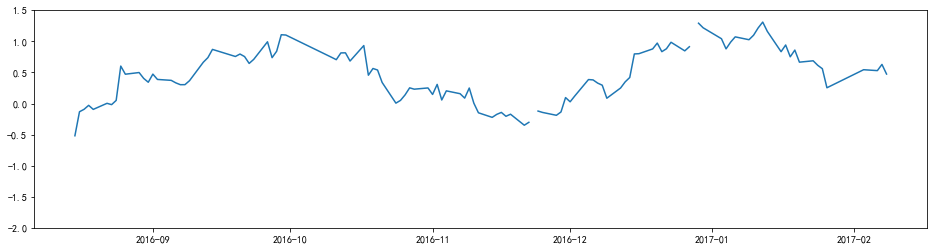

In [59]:
fig3 = plt.figure(figsize=(16,4))
plt.plot(df['skew'].iloc[370:485])
plt.ylim([-2,1.5])

对比胡昌生和程志富（2019）计算的隐含偏度的结果，时间窗口为2016年8月16日到2017年2月9日，可见两图的趋势一致。

![title](./1.png)

## 参考文献

[1] Bakshi G , Kapadia N . Delta-Hedged Gains and the Negative Market Volatility Risk Premium[J]. Review of Financial Studies, 2003, 16(2):527-566.

[2] Elisa Alòs, Jorge A. León. On the short-maturity behaviour of the implied volatility skew for random strike options and applications to option pricing approximation[J]. Quantitative Finance, 2016, 16.

[3] 胡昌生,程志富. 投资者情绪对上证50ETF隐含分布偏度影响的实证研究[J]. 数理统计与管理, 2019, 38(03):549-560.